# Advection constrain
<div class="alert alert-block alert-info">
ℹ️ This notebook describes the use of an advection constrain in the gridding.<br>
This constrains allows one to take into account a velocity field. 
</div>

In [1]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using Statistics
include("../config.jl")

"https://dox.uliege.be/index.php/s/IsWWlNxWeQDuarJ/download"

## Function to interpolate

In [2]:
fun(x,y) = sin.(6x) * cos.(6y)

# observations
x = rand(1);
y = rand(1);
f = fun.(x,y)

# final grid
xi,yi = ndgrid(range(0,stop=100,length=100), range(0,stop=110,length=110));

# reference field
fref = fun.(xi,yi);

### Simple plot

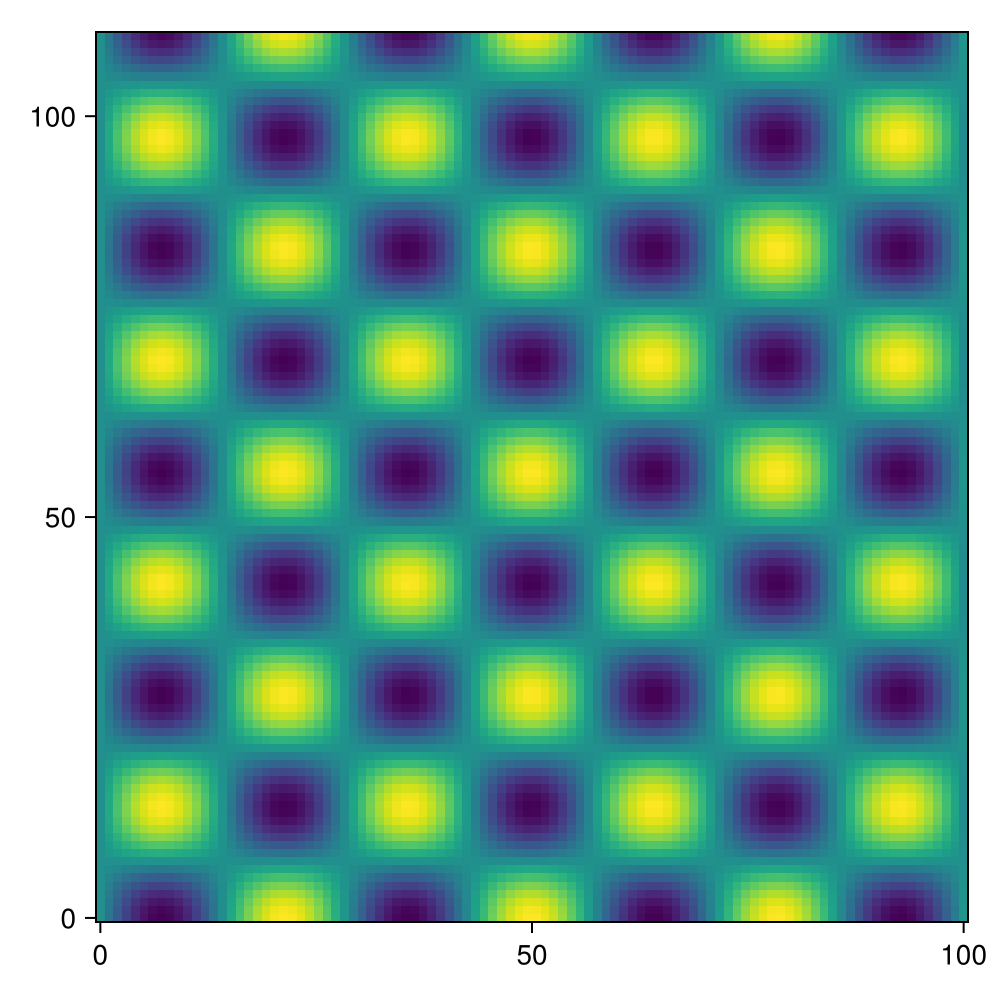

In [3]:
fig = Figure(size = (500, 500))
ax = Axis(fig[1,1])
heatmap!(ax, xi[:,1], yi[1,:], fref)
fig

## Create mask

In [4]:
mask = trues(size(xi));

# Add false along the edges
mask[1,:] .= false;
mask[end,:] .= false;
mask[:,1] .= false;
mask[:,end] .= false;

# island
mask[30:80,30:80] .= false;

### Simple plot
Note the `false` values along the borders.

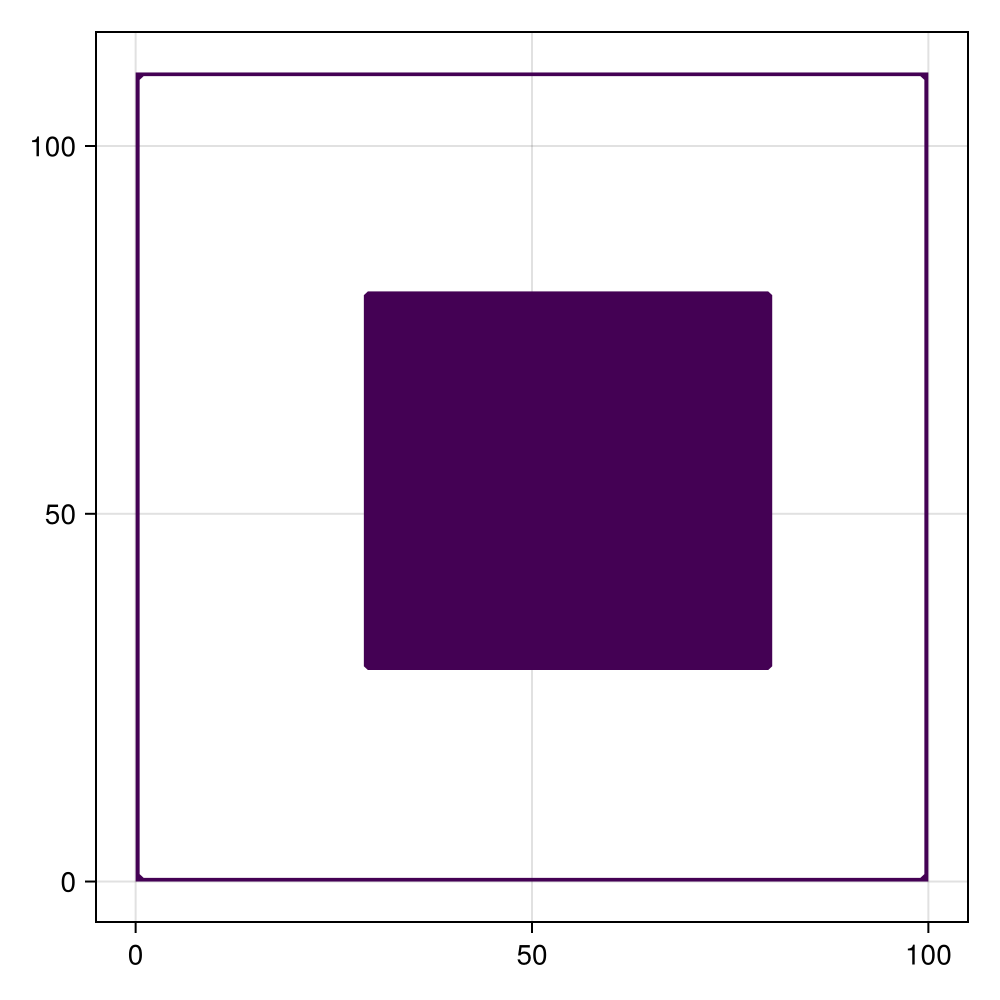

In [5]:
fig = Figure(size = (500, 500))
ax = Axis(fig[1,1])
contourf!(ax, xi[:,1], yi[1,:], mask, levels=[-.5, .5])
fig

## Set metrics and analysis parameters

In [6]:
# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

# correlation length
len = 10;

# obs. error variance normalized by the background error variance
epsilon2 = 10000000.;

## Advection along isobaths
`h` is the artificial topography, it has the same size as the computation grid 

[ Info: (100, 110)


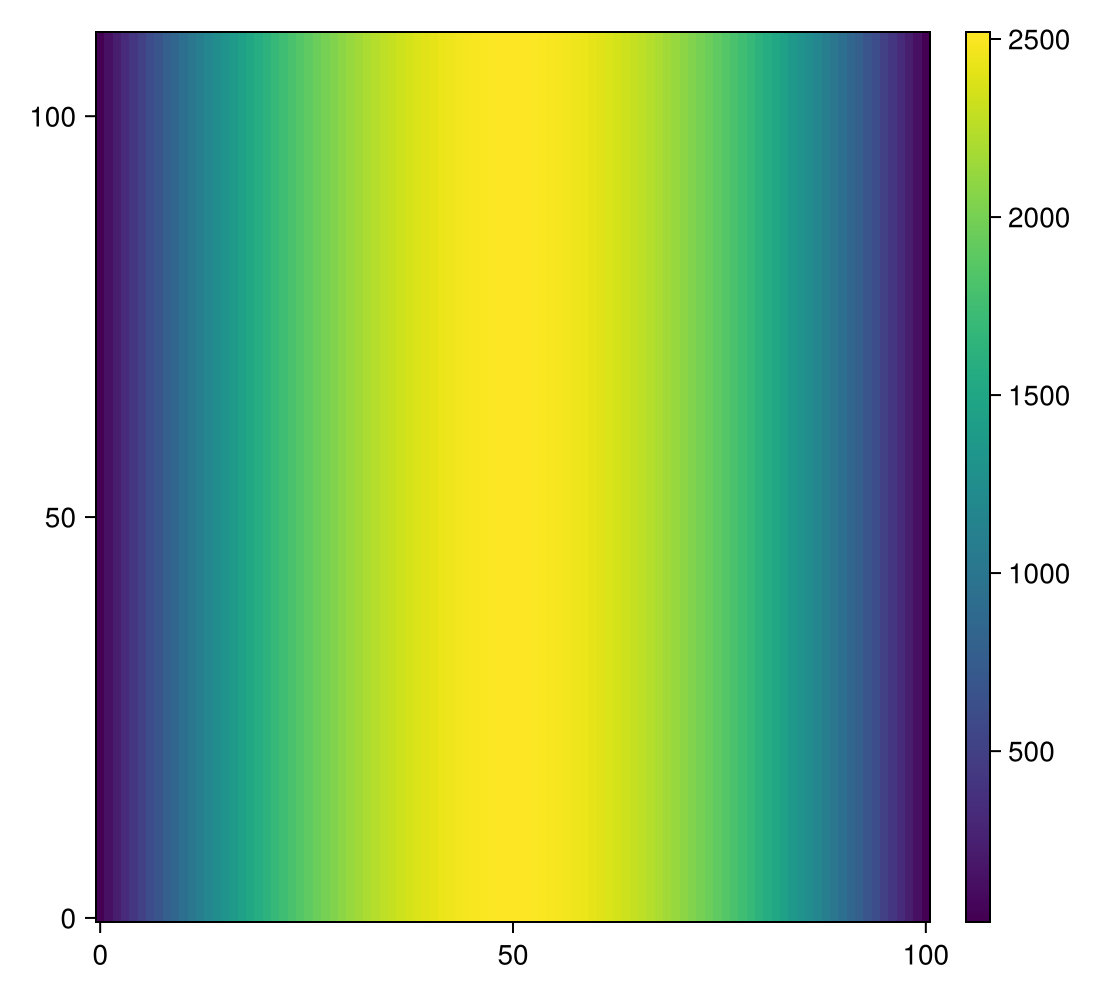

In [7]:
h = xi .* (100 .- xi) .+ 20;
@info(size(h))

fig = Figure(size = (550, 500))
ax = Axis(fig[1,1])
hm = heatmap!(ax, xi[:,1], yi[1,:], h)
Colorbar(fig[1,2], hm)
fig

### Advection through velocity field
We define the 2 components of the velocity field field.     
`rfluxes` specifies the error variance on the constraint.    

In [8]:
fluxes1 = sin.(yi[1,:]./10.)+0.1*rand(size(h)[2])
fluxes2 = sin.(xi[:,1]./10.)+0.1*rand(size(h)[1])
rfluxes = 1;

In [9]:
@info(size(fluxes1), size(fluxes2));

┌ Info: (110,)
└   size(fluxes2) = (100,)


## Analysis
The first arguments of `DIVAndrun` are the same as a classical analysis.     
Then we add:
* `topographyforfluxes`: a tuple of 2 elements, one for each horizontal component, for the advection along isobath.
* `fluxes`: a tuple of 2 elements storing the pseudo-velocity field.
* `epsfluxes`: a scalar defining the error variance on the constraint.
### Run with one component

In [10]:
@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;
    topographyforfluxes=(h,0),fluxes=(fluxes1,0),epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

 32.796142 seconds (35.48 M allocations: 2.248 GiB, 5.07% gc time, 98.10% compilation time)


#### Plot

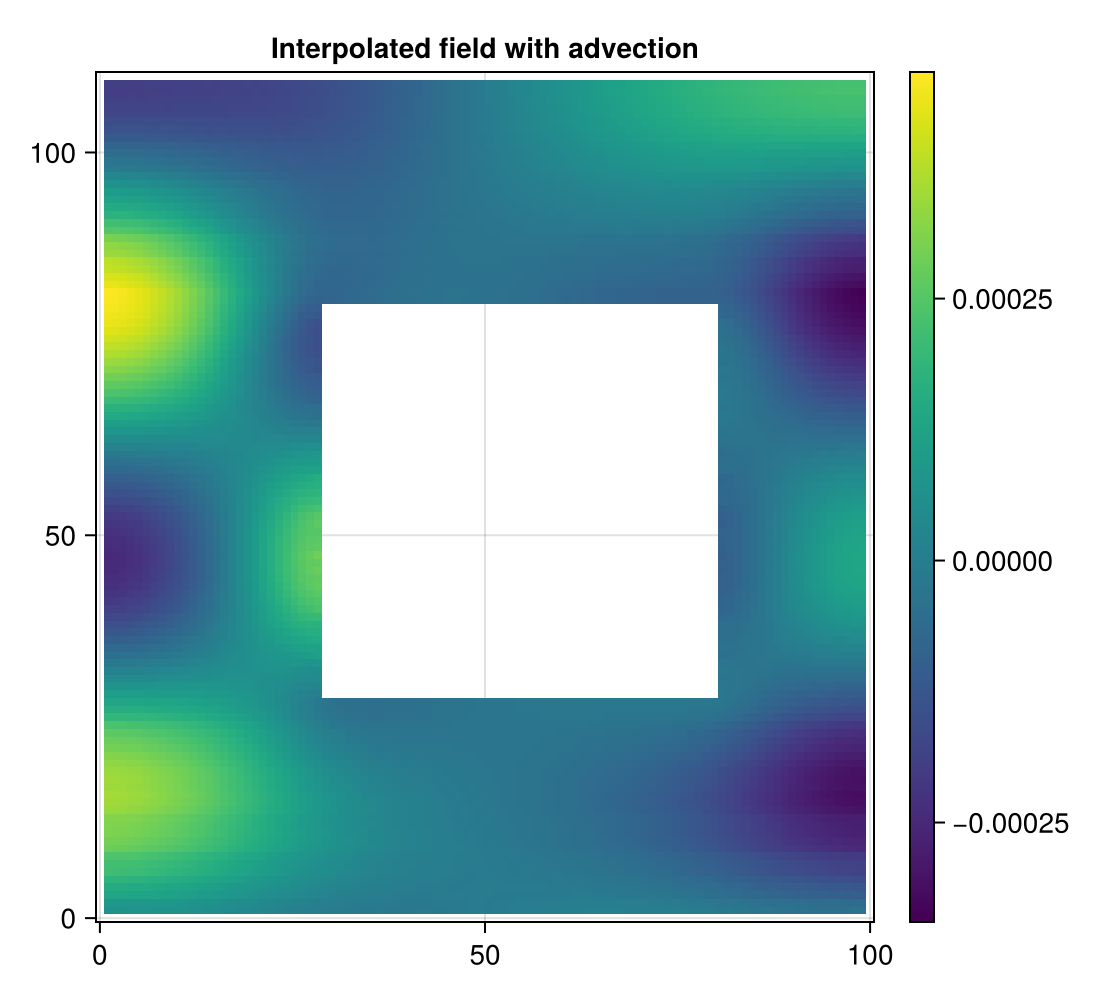

In [11]:
fig = Figure(size = (550, 500))
ax = Axis(fig[1,1], title="Interpolated field with advection")
hm = heatmap!(ax, xi[:,1], yi[1,:], fi)
Colorbar(fig[1,2], hm)
fig

### Run with the other component

In [12]:
fluxesafter=zeros(size(h)[2])

for j=1:size(h)[2]
 for i=2:size(h)[1]-2
	if mask[i,j]&& mask[i+1,j]
 		fluxesafter[j]=fluxesafter[j]+h[i,j]*(fi[i+1,j]-fi[i,j])
	end
 end
end
@show var(fluxes1+fluxesafter)
@show var(fluxes1)

@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;
    topographyforfluxes=(0,h),fluxes=(0,fluxes2),epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

var(fluxes1 + fluxesafter) = 0.007680477757823818
var(fluxes1) = 0.4969504777755853
  1.398904 seconds (724.45 k allocations: 434.218 MiB, 9.64% gc time, 67.23% compilation time)


#### Plot

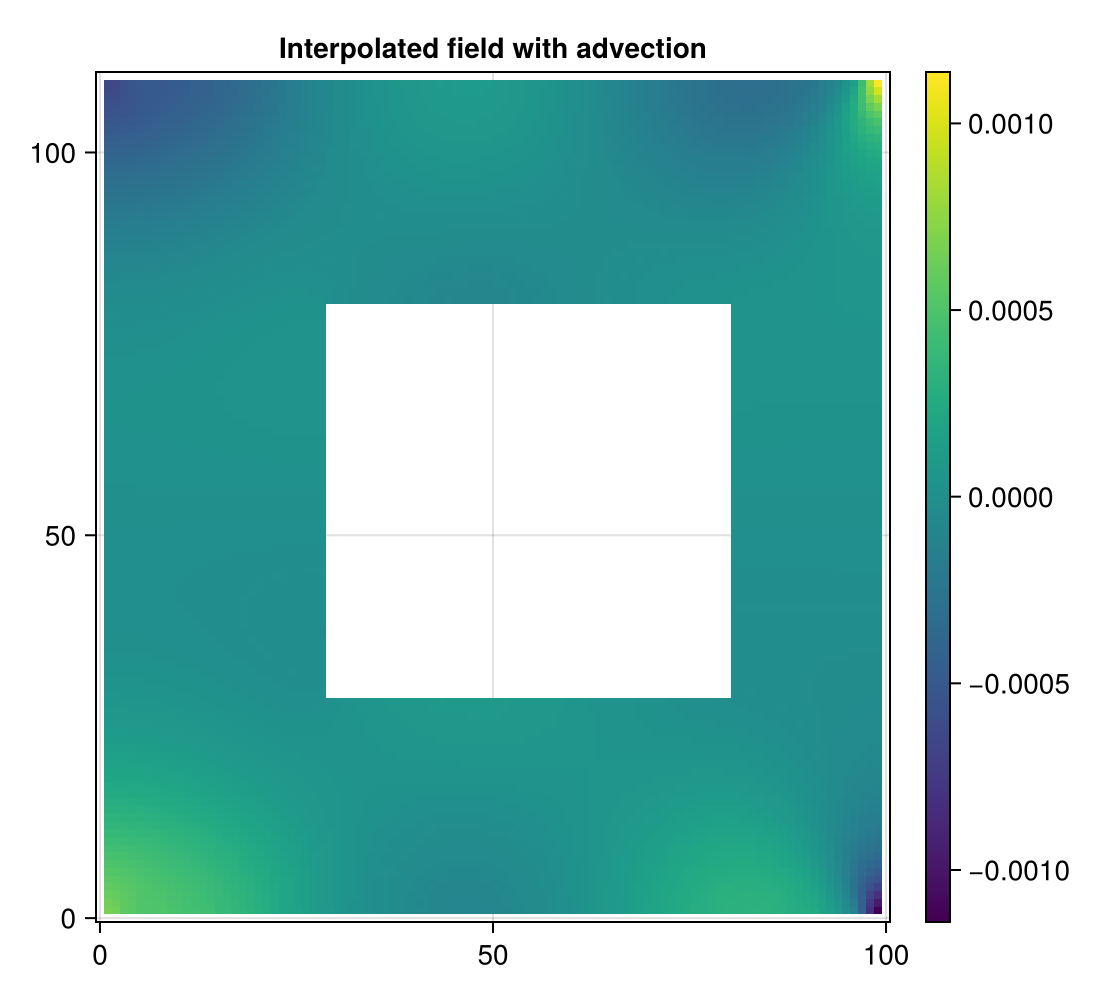

In [13]:
fig = Figure(size = (550, 500))
ax = Axis(fig[1,1], title="Interpolated field with advection")
hm = heatmap!(ax, xi[:,1], yi[1,:], fi)
Colorbar(fig[1,2], hm)
fig

### Finally using both components

In [14]:
fluxesafter=zeros(size(h)[1])

for i=1:size(h)[1]
    for j=2:size(h)[2]-2
        if mask[i,j]&& mask[i,j+1]
            fluxesafter[i]=fluxesafter[i]+h[i,j]*(fi[i,j+1]-fi[i,j])
        end
    end
end
 
@show var(fluxes2+fluxesafter)
@show var(fluxes2)

# finally both directions
@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;
    topographyforfluxes=(h,h),fluxes=(fluxes1,fluxes2),epsfluxes=rfluxes,alphabc=1,alpha=[1, 0, 1]);

var(fluxes2 + fluxesafter) = 0.002504393819665692
var(fluxes2) = 0.4465625307607096
  2.593517 seconds (694.53 k allocations: 871.075 MiB, 34.98% gc time, 39.01% compilation time)


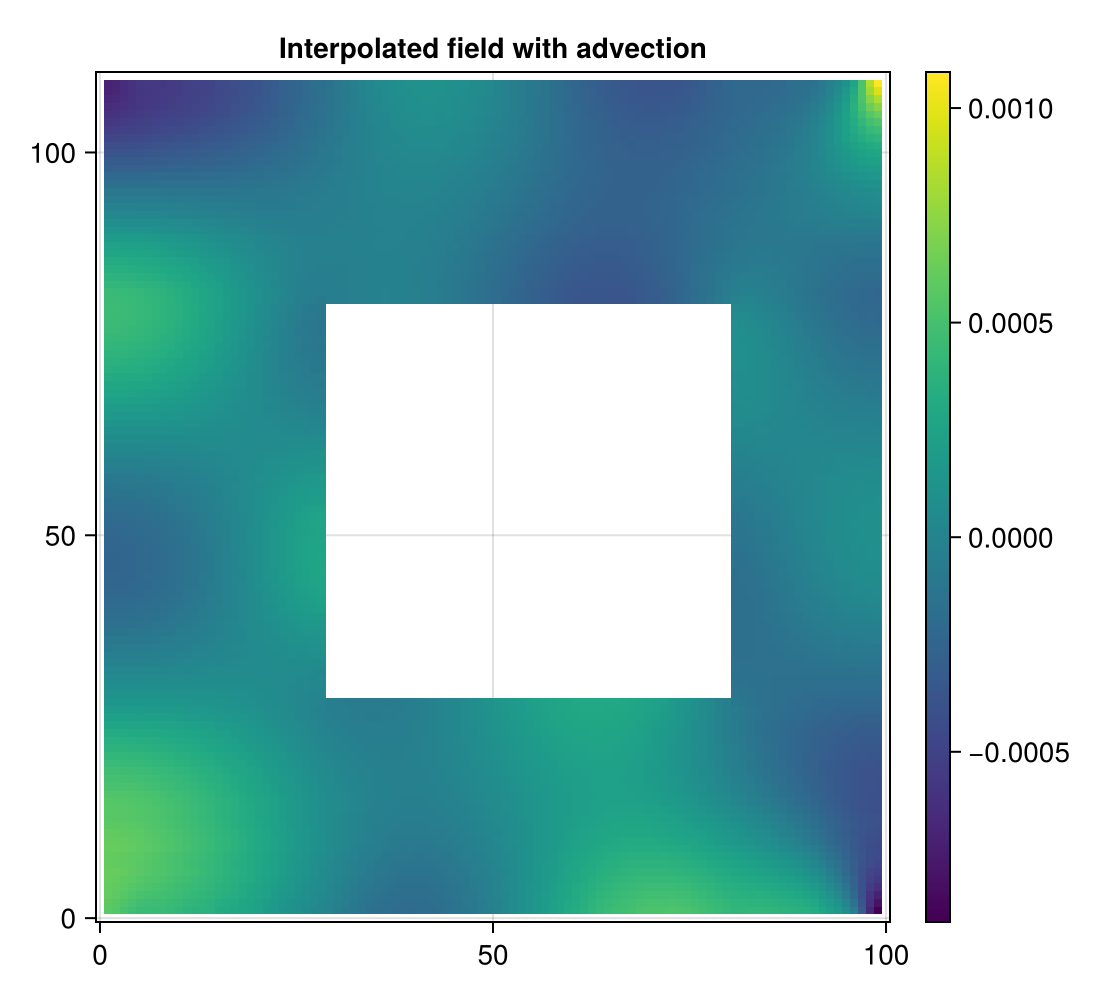

In [15]:
fig = Figure(size = (550, 500))
ax = Axis(fig[1,1], title="Interpolated field with advection")
hm = heatmap!(ax, xi[:,1], yi[1,:], fi)
Colorbar(fig[1,2], hm)
fig

In [16]:
fluxesafter=zeros(size(h)[2])

for j=1:size(h)[2]
    for i=2:size(h)[1]-2
        if mask[i,j]&& mask[i+1,j]
            fluxesafter[j]=fluxesafter[j]+h[i,j]*(fi[i+1,j]-fi[i,j])
        end
    end
end
@show var(fluxes1+fluxesafter)
@show var(fluxes1)

fluxesafter=zeros(size(h)[1])

for i=1:size(h)[1]
    for j=2:size(h)[2]-2
        if mask[i,j]&& mask[i,j+1]
            fluxesafter[i]=fluxesafter[i]+h[i,j]*(fi[i,j+1]-fi[i,j])
        end
    end
end
 
@show var(fluxes2+fluxesafter)
@show var(fluxes2);

var(fluxes1 + fluxesafter) = 0.007832159288714162
var(fluxes1) = 0.4969504777755853
var(fluxes2 + fluxesafter) = 0.00263183491539797
var(fluxes2) = 0.4465625307607096
